# COVID-19 Data Analysis Project

### Timo Maier

This notebook contains experiments and code of the data analysis project. We aim to use publicly available data on the Covid pandemic (mainly from ourworldindata.org) to investigate how different countries reacted to the pandemic, what role testing policies play  in terms of death tolls, and how vaccinations influece the death rates and the importance of testing. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
import math
import scipy.stats as scipy

### Load Our World in Data COVID dataset

In [3]:
owid_url = 'https://github.com/owid/covid-19-data/raw/master/public/data/owid-covid-data.csv'

data = pd.read_csv(owid_url)

In [4]:
data.info()
data['iso_code'].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132430 entries, 0 to 132429
Data columns (total 65 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   iso_code                                 132430 non-null  object 
 1   continent                                123969 non-null  object 
 2   location                                 132430 non-null  object 
 3   date                                     132430 non-null  object 
 4   total_cases                              125203 non-null  float64
 5   new_cases                                125201 non-null  float64
 6   new_cases_smoothed                       124158 non-null  float64
 7   total_deaths                             114094 non-null  float64
 8   new_deaths                               114290 non-null  float64
 9   new_deaths_smoothed                      124158 non-null  float64
 10  total_cases_per_million         

array(['AFG', 'OWID_AFR', 'ALB', 'DZA', 'AND', 'AGO', 'AIA', 'ATG', 'ARG',
       'ARM', 'ABW', 'OWID_ASI', 'AUS', 'AUT', 'AZE', 'BHS', 'BHR', 'BGD',
       'BRB', 'BLR', 'BEL', 'BLZ', 'BEN', 'BMU', 'BTN', 'BOL', 'BES',
       'BIH', 'BWA', 'BRA', 'VGB', 'BRN', 'BGR', 'BFA', 'BDI', 'KHM',
       'CMR', 'CAN', 'CPV', 'CYM', 'CAF', 'TCD', 'CHL', 'CHN', 'COL',
       'COM', 'COG', 'COK', 'CRI', 'CIV', 'HRV', 'CUB', 'CUW', 'CYP',
       'CZE', 'COD', 'DNK', 'DJI', 'DMA', 'DOM', 'ECU', 'EGY', 'SLV',
       'GNQ', 'ERI', 'EST', 'SWZ', 'ETH', 'OWID_EUR', 'OWID_EUN', 'FRO',
       'FLK', 'FJI', 'FIN', 'FRA', 'PYF', 'GAB', 'GMB', 'GEO', 'DEU',
       'GHA', 'GIB', 'GRC', 'GRL', 'GRD', 'GTM', 'GGY', 'GIN', 'GNB',
       'GUY', 'HTI', 'OWID_HIC', 'HND', 'HKG', 'HUN', 'ISL', 'IND', 'IDN',
       'OWID_INT', 'IRN', 'IRQ', 'IRL', 'IMN', 'ISR', 'ITA', 'JAM', 'JPN',
       'JEY', 'JOR', 'KAZ', 'KEN', 'KIR', 'OWID_KOS', 'KWT', 'KGZ', 'LAO',
       'LVA', 'LBN', 'LSO', 'LBR', 'LBY', 'LIE', 'LTU', 'OWID_

## 1) Preparing the data

Now we want to do a similar analysis to Middelhoff (2020), for this we need for the countries we want to examine
1. the date of the first confirmed death. This will be the index date for the country
2. day 25 after the index date
   
When we have this we can appropriately compare the countries.

In [5]:
data['date'] = pd.to_datetime(data['date'])
countries = data['iso_code'].unique()
ctr_idx = pd.DataFrame(countries, columns=['iso_code'])
indices = []

# iterate over countries, for each get rows with new deaths and find min date as index
for idx, ctr in enumerate(countries):
    data_ctr = data.loc[data['iso_code'] == ctr]
    new_deaths = data_ctr.loc[data_ctr['new_deaths'].notna()]
    if len(new_deaths) > 0:
        indices.append(min(new_deaths['date']))
    else:
        indices.append(pd.Timestamp('2018-01-01'))

# now we have new table that maps iso code to index date
ctr_idx['index_date'] = pd.Series(indices, dtype='datetime64[ns]')

Now we want to find the number of deaths on day 25 *after* the index date, so we can express deaths
in the future as a percentage of this number:

In [6]:
deaths = []

# add 25 days to first death date and find total deaths on this date for each country (fill with NaN if zero)
for ctr in countries:
    day25 = ctr_idx.loc[ctr_idx['iso_code'] == ctr]['index_date'] + pd.Timedelta(25, 'D')
    day25 = pd.Timestamp(day25.values[0])
    d25_deaths = data.loc[(data['iso_code'] == ctr) & (data['date'] == day25)]['total_deaths']
    if len(d25_deaths) > 0:
        deaths.append(d25_deaths.values[0])
    else:
        deaths.append('NaN')

ctr_idx['deaths_day25'] = pd.Series(deaths, dtype='float64')
ctr_idx.head()

,iso_code,index_date,deaths_day25
0,AFG,2020-03-23,30.0
1,OWID_AFR,2020-02-13,1.0
2,ALB,2020-03-11,20.0
3,DZA,2020-03-12,173.0
4,AND,2020-03-22,33.0


### First visualization and inspection

Let's look into our newly created table to find some interesting information.
We plot the index date against the reported deaths on day 25 after the first death.
To simplify analysis, we only select a number of countries.

In [7]:
ctr_of_interest = ['ITA', 'GBR', 'DEU', 'SWE', 'PRT', 'USA', 'BEL', 'KOR', 'DNK', 'TWN', 'THA']

In [8]:
#ctr_of_interest = ['ITA', 'GBR', 'DEU', 'SWE', 'PRT', 'USA', 'BEL', 'KOR', 'DNK']

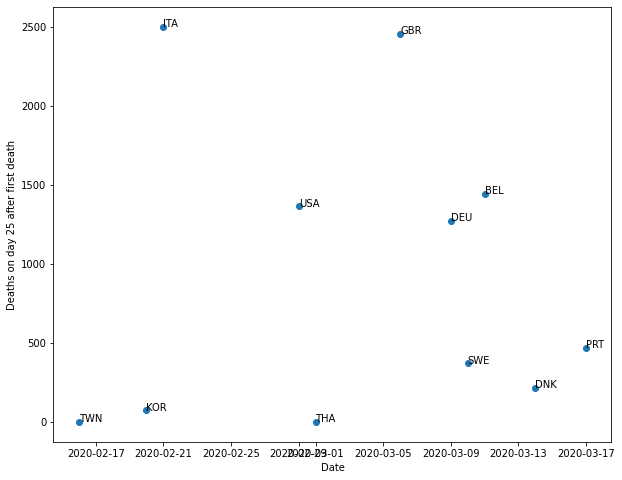

In [9]:
df_plot = ctr_idx.loc[ctr_idx['iso_code'].isin(ctr_of_interest)]

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(df_plot["index_date"], df_plot["deaths_day25"])
ax.set_ylabel("Deaths on day 25 after first death")
ax.set_xlabel("Date")

for i, txt in zip(df_plot.index, df_plot['iso_code']):
    ax.annotate(txt, (df_plot["index_date"][i], df_plot["deaths_day25"][i]))


#plt.savefig('figures/pandemic_begin_country_assessment')

Here we can see how "hard" the countries were hit by the pandemic and how well they responded to the first outbreak.
Explanation for ESP: Spain had a spike of deaths just after the first death (which was possibly identified rather late), so on day 25 there were a lot of deaths. However in the curves below Spain does not fall out of proportion, because we relate future deaths to the number on day 25 (which is very high in Spain), so the precentage after it is rather low compared to other countries. This effect could be seen as a drawback of the method of Middelhoff & Rosendaal.
**This method/criterion is particularly useful to assess how the pandemic started in each country (the first weeks)**. Subsequent measures can then be assessed by the curves of cumulated deaths.



## 2) Make data comparable by removing difficulties (according to Middelhoff & Rosendaal)


  - The different scales of cases/deaths (they argue even deaths/100k is not appropriate. The idea is to express the **cumulative deaths as % of deaths on day 25 after the first recorded death** in each country.

  
  - The time delay: Countries are hit by pandemic on different dates, makes comparison difficult. Thus, we move away from the actual *date*, and consider the **days after first recorded death**. This layers the curves of deaths on top of each other, easy for comparison.

In [10]:
# select our countries of interest from the complete table
# and the table containing index dates and day25 deaths 

data_n = data.loc[data['iso_code'].isin(ctr_of_interest)]

idx_deaths = ctr_idx.loc[ctr_idx['iso_code'].isin(ctr_of_interest)].sort_values(['iso_code'])
idx_deaths = idx_deaths.reset_index()

In [11]:
# we want to look 150 days after the first death
timedelta = pd.Timedelta(800, 'D')

In [12]:
tables = []

# find the index date and the number of deaths on day 25
# list the first 150 days after index
for ctr in ctr_of_interest:
    day25 = idx_deaths.loc[idx_deaths['iso_code'] == ctr]['deaths_day25'].values[0]
    index_date = idx_deaths.loc[idx_deaths['iso_code'] == ctr]['index_date'].values[0]


    table = data_n.loc[(data_n['iso_code'] == ctr) & (data_n['date'] >= index_date) 
                 & (data_n['date'] < index_date + timedelta)]
    
    table['percent_deaths'] = table['total_deaths'] / day25 * 100
    table['mortality'] =  (table['total_deaths'].tail(1) / table['population'] * 100000) / (table['total_cases'].tail(1) / table['population'] * 100000)
    table = table.reset_index()
    tables.append(table)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
colors = {'BEL': 'C0', 'DNK': 'darkorange', 'DEU': 'green', 'ITA': 'blue', 'USA': 'purple', 'KOR': 'grey',
         'PRT': 'RED', 'GBR': 'brown', 'SWE': 'pink', 'TWN': 'darkgreen', 'THA': 'darkgrey'}

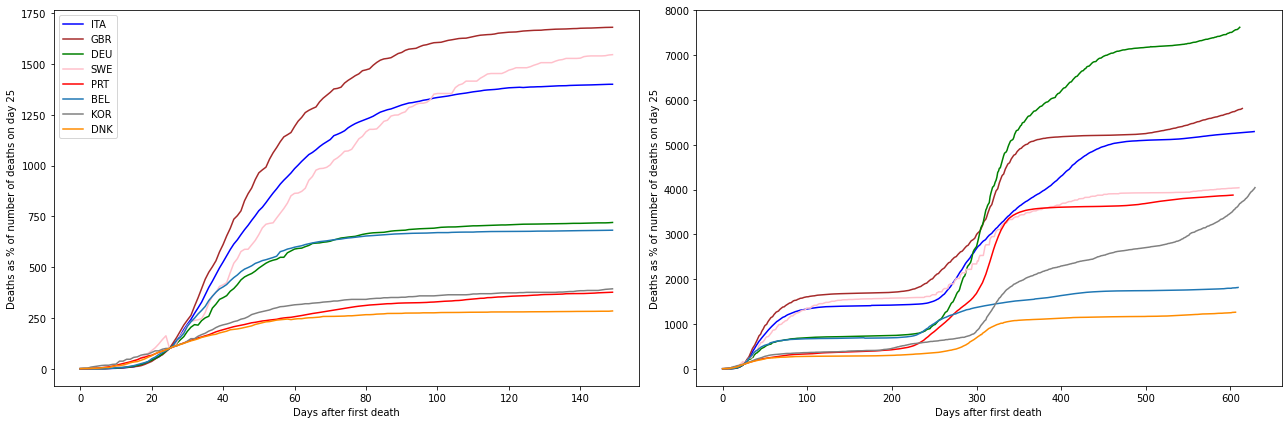

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6))

for table in tables:
    if table['iso_code'].values[0] == 'USA' or table['iso_code'].values[0] == 'TWN' or table['iso_code'].values[0] == 'THA':
        continue 
    ax1.plot(table[:150].index, table['percent_deaths'][:150], label=table['iso_code'].values[0], color=colors[table['iso_code'].values[0]])
    ax2.plot(table.index, table['percent_deaths'], label=table['iso_code'].values[0], color=colors[table['iso_code'].values[0]])

ax1.legend()
ax1.set_ylabel('Deaths as % of number of deaths on day 25')
ax2.set_ylabel('Deaths as % of number of deaths on day 25')
ax1.set_xlabel('Days after first death')
ax2.set_xlabel('Days after first death')
plt.tight_layout()
plt.savefig('figures/deaths_combined_2plot')

In [15]:
# save indices of countries needed for easier access in a table
ger_idx = 0
ita_idx = 0
gbr_idx = 0
usa_idx = 0
bel_idx = 0
dnk_idx = 0
kor_idx = 0
prt_idx = 0
twn_idx = 0
tha_idx = 0
sgp_idx = 0
mys_idx = 0
vnm_idx = 0
for i, t in enumerate(tables):
    if t['iso_code'].values[0] == 'DEU':
        ger_idx = i
    if t['iso_code'].values[0] == 'ITA':
        ita_idx = i
    if t['iso_code'].values[0] == 'GBR':
        gbr_idx = i
    if t['iso_code'].values[0] == 'USA':
        usa_idx = i
    if t['iso_code'].values[0] == 'BEL':
        bel_idx = i
    if t['iso_code'].values[0] == 'DNK':
        dnk_idx = i
    if t['iso_code'].values[0] == 'KOR':
        kor_idx = i
    if t['iso_code'].values[0] == 'PRT':
        prt_idx = i
    if t['iso_code'].values[0] == 'TWN':
        twn_idx = i
    if t['iso_code'].values[0] == 'THA':
        tha_idx = i

In [63]:
s = 0
for t in tables:
    s += t['mortality'].tail(1).values[0]
s = s / len(tables)

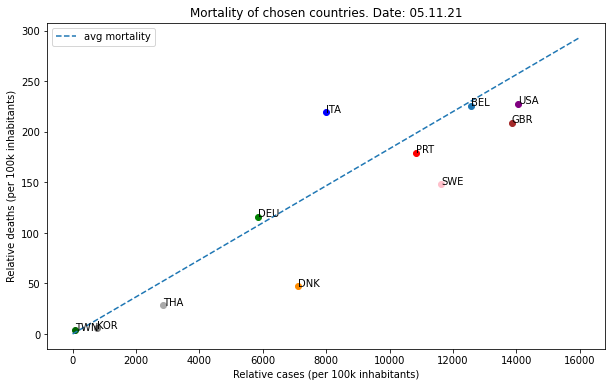

In [64]:
fig, ax = plt.subplots(figsize=(10,6))

for table in tables:
    cases = table['total_cases'].tail(1).values[0] * 100000 / table['population'].values[0]
    deaths = table['total_deaths'].tail(1).values[0] * 100000 / table['population'].values[0]
    ax.scatter(cases, deaths, color=colors[table['iso_code'].values[0]])
    ax.annotate(table['iso_code'].values[0], xy=(cases, deaths))

ax.plot(np.arange(0, 16000), np.arange(0, 16000) * s, linestyle='--', label="avg mortality")
ax.set_ylabel('Relative deaths (per 100k inhabitants)')
ax.set_xlabel('Relative cases (per 100k inhabitants)')
ax.set_title('Mortality of chosen countries. Date: 05.11.21')
ax.legend()
plt.savefig('figures/mortality_plot')

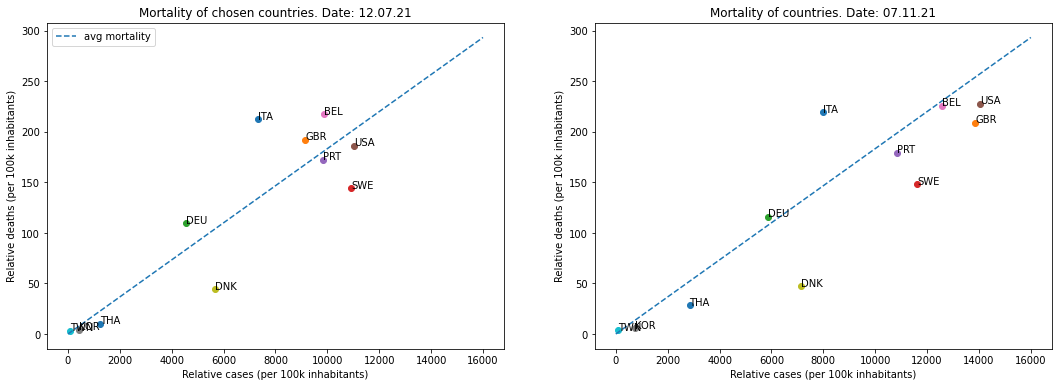

In [52]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6))

for table in tables:
    cases = table['total_cases'].tail(1).values[0] * 100000 / table['population'].values[0]
    deaths = table['total_deaths'].tail(1).values[0] * 100000 / table['population'].values[0]
    ax2.scatter(cases, deaths)
    ax2.annotate(table['iso_code'].values[0], xy=(cases, deaths))

ax1.plot(np.arange(0, 16000), np.arange(0, 16000) * s, linestyle='--', label="avg mortality")
ax1.set_ylabel('Relative deaths (per 100k inhabitants)')
ax1.set_xlabel('Relative cases (per 100k inhabitants)')
ax1.set_title('Mortality of chosen countries. Date: 12.07.21')
ax1.legend()

for table in tables:
    cases = table['total_cases'].tail(90).values[0] * 100000 / table['population'].values[0]
    deaths = table['total_deaths'].tail(90).values[0] * 100000 / table['population'].values[0]
    ax1.scatter(cases, deaths)
    ax1.annotate(table['iso_code'].values[0], xy=(cases, deaths))

ax2.plot(np.arange(0, 16000), np.arange(0, 16000) * s, linestyle='--')
ax2.set_ylabel('Relative deaths (per 100k inhabitants)')
ax2.set_xlabel('Relative cases (per 100k inhabitants)')
ax2.set_title('Mortality of countries. Date: 07.11.21')
plt.savefig('figures/talk/mortality_2plot')

## 3) Incorporating the Stringency Index

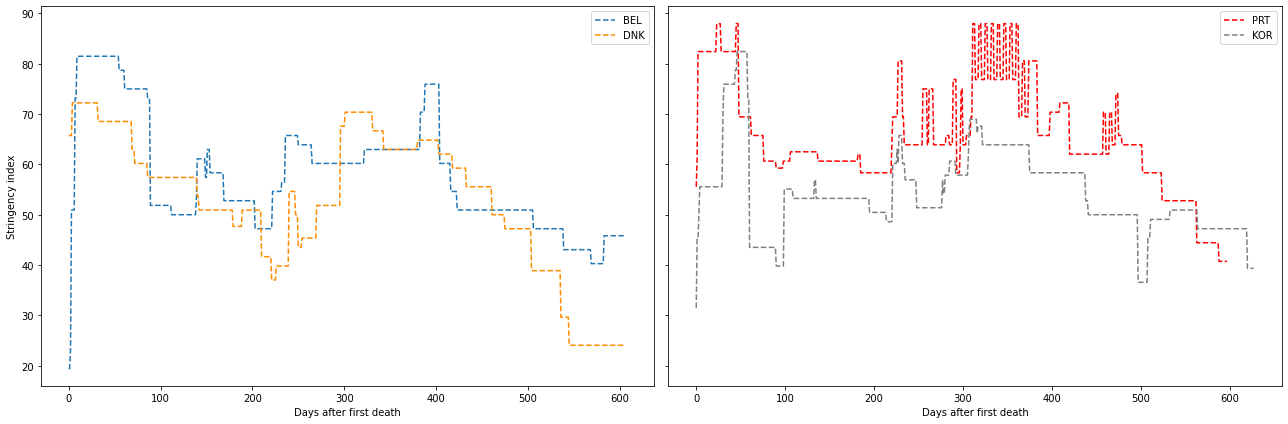

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6), sharey=True)
ax1.plot(tables[bel_idx].index, tables[bel_idx]['stringency_index'], label=tables[bel_idx]['iso_code'].values[0], linestyle='--', color=colors['BEL'])
ax1.plot(tables[dnk_idx].index, tables[dnk_idx]['stringency_index'], label=tables[dnk_idx]['iso_code'].values[0], linestyle='--', color=colors['DNK'])
ax2.plot(tables[prt_idx].index, tables[prt_idx]['stringency_index'], label=tables[prt_idx]['iso_code'].values[0], linestyle='--', color=colors['PRT'])
ax2.plot(tables[kor_idx].index, tables[kor_idx]['stringency_index'], label=tables[kor_idx]['iso_code'].values[0], linestyle='--', color=colors['KOR'])

ax1.legend()
ax2.legend()
ax1.set_ylabel('Stringency index')
ax1.set_xlabel('Days after first death')
ax2.set_xlabel('Days after first death')
plt.tight_layout()
plt.savefig('figures/stringency_2plot')

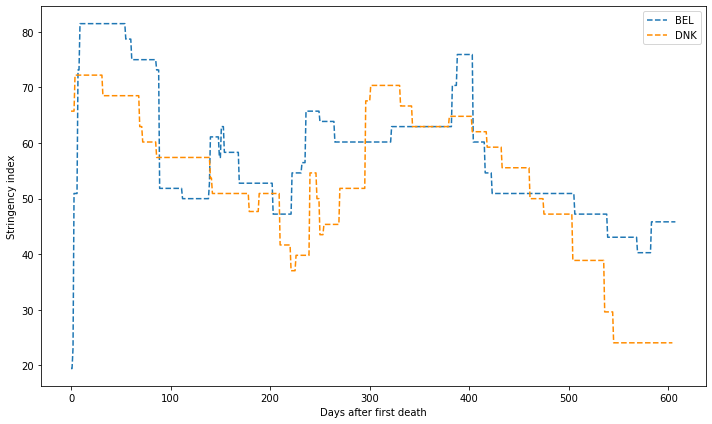

In [60]:
plt.figure(figsize=(10,6))
plt.plot(tables[bel_idx].index, tables[bel_idx]['stringency_index'], label=tables[bel_idx]['iso_code'].values[0], linestyle='--', color=colors['BEL'])
plt.plot(tables[dnk_idx].index, tables[dnk_idx]['stringency_index'], label=tables[dnk_idx]['iso_code'].values[0], linestyle='--', color=colors['DNK'])

plt.legend()
plt.ylabel('Stringency index')
plt.xlabel('Days after first death')

plt.tight_layout()
plt.savefig('figures/talk/stringency2')

## 4) Comparison of BEL, DNK

The plot above that plots date of first case against the number of deaths on day 25 after first recorded deaths shows some interesting information. First, it shows that it is rather unfair to, e.g., compare ESP or ITA with KOR or SWE, because the former were hit much harder by the pandemic, probably had a lot of cases already before the first death.

Secondly, it shows us *what* is fair to compare: HUN and DNK are very close together in this plot, number of deaths are rather the same and they were hit at the same time. But then if we look at another plot above, showing the curves of deaths in relation of deaths on day25, they differ very much. HUN has a much higher mortality. Now we can look at testing strategies and stringency index to find reasons for this.

### Testing

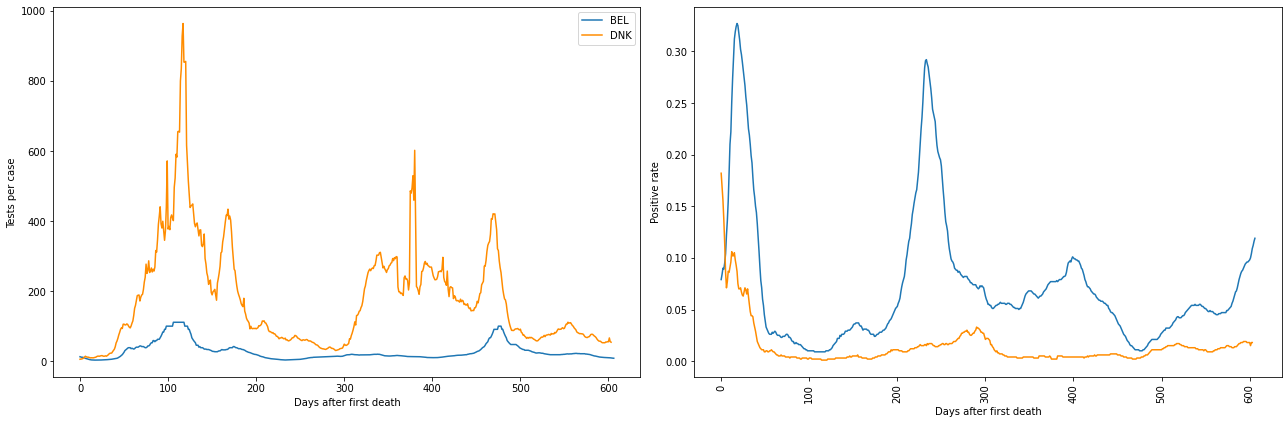

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(18,6))

ax1.plot(tables[bel_idx].index, tables[bel_idx]['tests_per_case'], label=tables[bel_idx]['iso_code'].values[0], color=colors['BEL'])
ax1.plot(tables[dnk_idx].index, tables[dnk_idx]['tests_per_case'], label=tables[dnk_idx]['iso_code'].values[0], color=colors['DNK'])
ax2.plot(tables[bel_idx].index, tables[bel_idx]['positive_rate'], color=colors['BEL'])
ax2.plot(tables[dnk_idx].index, tables[dnk_idx]['positive_rate'], color=colors['DNK'])
ax1.legend()
plt.xticks(rotation=90)
ax1.set_ylabel('Tests per case')
ax1.set_xlabel('Days after first death')
ax2.set_ylabel('Positive rate')
ax2.set_xlabel('Days after first death')
plt.tight_layout()
plt.savefig('figures/testing_bel_dnk')

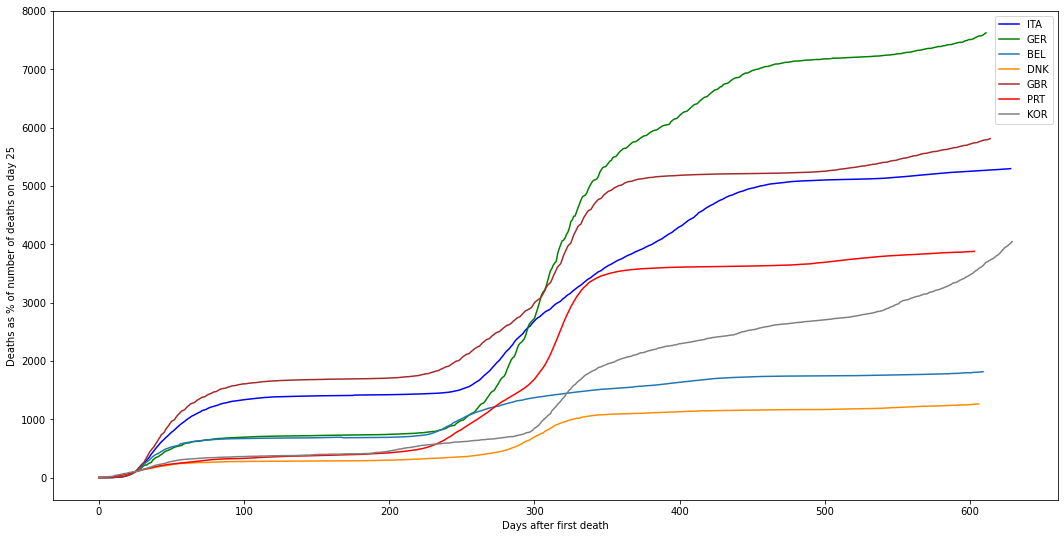

In [21]:
plt.figure(figsize=(18,9))
plt.plot(tables[ita_idx].index, tables[ita_idx]['percent_deaths'], label='ITA', color=colors['ITA'])
plt.plot(tables[ger_idx].index, tables[ger_idx]['percent_deaths'], label='GER', color=colors['DEU'])
plt.plot(tables[bel_idx].index, tables[bel_idx]['percent_deaths'], label='BEL', color=colors['BEL'])
plt.plot(tables[dnk_idx].index, tables[dnk_idx]['percent_deaths'], label='DNK', color=colors['DNK'])
plt.plot(tables[gbr_idx].index, tables[gbr_idx]['percent_deaths'], label='GBR', color=colors['GBR'])
plt.plot(tables[prt_idx].index, tables[prt_idx]['percent_deaths'], label='PRT', color=colors['PRT'])
plt.plot(tables[kor_idx].index, tables[kor_idx]['percent_deaths'], label='KOR', color=colors['KOR'])
plt.legend()

plt.ylabel('Deaths as % of number of deaths on day 25')
plt.xlabel('Days after first death')
plt.savefig('figures/combined_deaths_all')

## Vaccinations

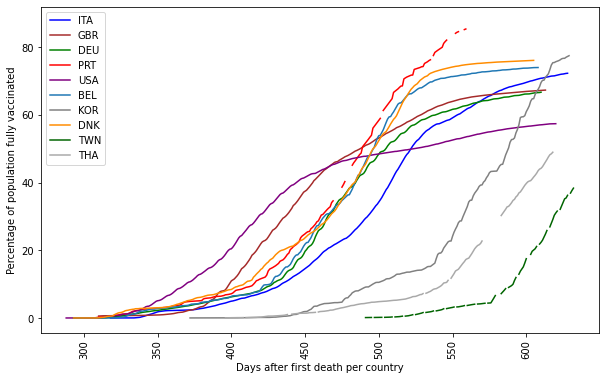

In [22]:
plt.figure(figsize=(10,6))

for table in tables:
    if table['iso_code'].values[0] == 'ESP' or table['iso_code'].values[0] == 'SWE':
        continue
    plt.plot(table.index, table['people_fully_vaccinated_per_hundred'], label=table['iso_code'].values[0], color=colors[table['iso_code'].values[0]])
plt.legend()
plt.xticks(rotation=90)
plt.ylabel('Percentage of population fully vaccinated')
plt.xlabel('Days after first death per country')
plt.savefig('figures/vaccinations')

In [129]:
bel_tests_yesterday = tables[bel_idx]['tests_per_case'].tail(2)
bel_vacc = tables[bel_idx]['people_fully_vaccinated_per_hundred']
bel_10 = tables[bel_idx]['people_fully_vaccinated_per_hundred'].loc[bel_vacc >= 10]
bel_fd = tables[bel_idx]['people_fully_vaccinated_per_hundred'].loc[bel_vacc >= 0.0]
bel_first_dose = bel_fd.index[0]
bel_ten_perc = bel_10.index[0]

dnk_tests_yesterday = tables[dnk_idx]['tests_per_case'].tail(2)
dnk_vacc = tables[dnk_idx]['people_fully_vaccinated_per_hundred']
dnk_10 = tables[dnk_idx]['people_fully_vaccinated_per_hundred'].loc[dnk_vacc >= 10]
dnk_fd = tables[dnk_idx]['people_fully_vaccinated_per_hundred'].loc[dnk_vacc >= 0.0]
dnk_first_dose = dnk_fd.index[0]
dnk_ten_perc = dnk_10.index[0]

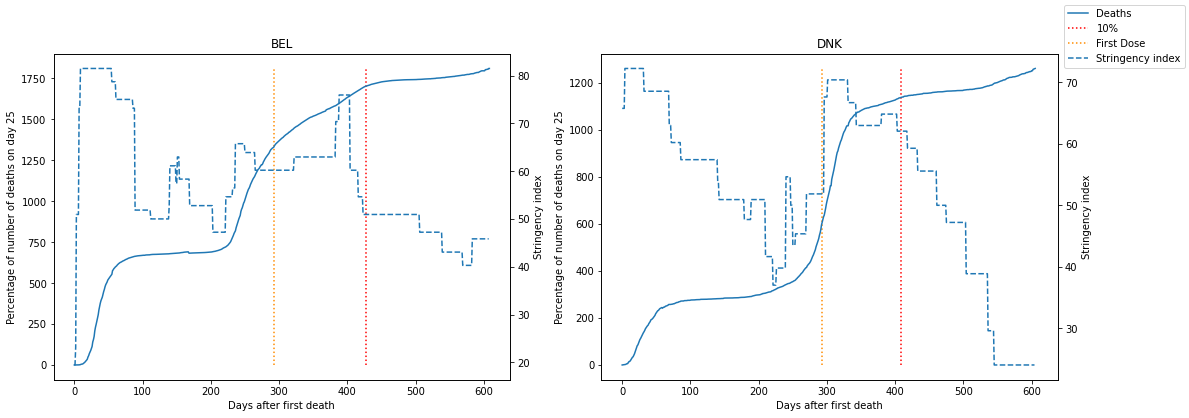

In [130]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(18,6))

ax3 = ax1.twinx()
ax1.plot(tables[bel_idx].index, tables[bel_idx]['percent_deaths'], label='Deaths', color='C0')
ax3.plot(tables[bel_idx].index, tables[bel_idx]['stringency_index'], label='Stringency index', color='C0', linestyle='--')
ax1.vlines(x=bel_ten_perc, ymin=min(tables[bel_idx]['percent_deaths']), ymax=max(tables[bel_idx]['percent_deaths']), linestyle='dotted', color='red', label="10%")
ax1.vlines(x=bel_first_dose, ymin=min(tables[bel_idx]['percent_deaths']), ymax=max(tables[bel_idx]['percent_deaths']), linestyle='dotted', color='darkorange', label="First Dose")

ax4 = ax2.twinx()
ax2.plot(tables[dnk_idx].index, tables[dnk_idx]['percent_deaths'])
ax4.plot(tables[dnk_idx].index, tables[dnk_idx]['stringency_index'], linestyle='--')
ax2.vlines(x=dnk_ten_perc, ymin=min(tables[dnk_idx]['percent_deaths']), ymax=max(tables[dnk_idx]['percent_deaths']), linestyle='dotted', color='red')
ax2.vlines(x=dnk_first_dose, ymin=min(tables[dnk_idx]['percent_deaths']), ymax=max(tables[dnk_idx]['percent_deaths']), linestyle='dotted', color='darkorange')

fig.legend()
plt.xticks(rotation=90)
ax1.set_xlabel('Days after first death')
ax2.set_xlabel('Days after first death')
ax1.set_title('BEL')
ax2.set_title('DNK')
ax1.set_ylabel('Percentage of number of deaths on day 25')
ax2.set_ylabel('Percentage of number of deaths on day 25')
ax3.set_ylabel('Stringency index')
ax4.set_ylabel('Stringency index')
#plt.tight_layout()
plt.savefig('figures/stringency_vacc_bel_den')

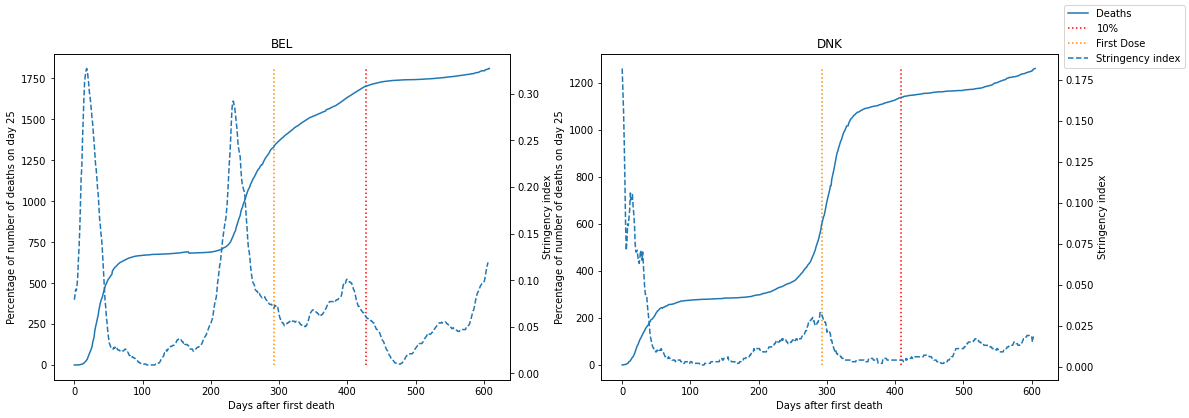

In [131]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(18,6))

ax3 = ax1.twinx()
ax1.plot(tables[bel_idx].index, tables[bel_idx]['percent_deaths'], label='Deaths', color='C0')
ax3.plot(tables[bel_idx].index, tables[bel_idx]['positive_rate'], label='Stringency index', color='C0', linestyle='--')
ax1.vlines(x=bel_ten_perc, ymin=min(tables[bel_idx]['percent_deaths']), ymax=max(tables[bel_idx]['percent_deaths']), linestyle='dotted', color='red', label="10%")
ax1.vlines(x=bel_first_dose, ymin=min(tables[bel_idx]['percent_deaths']), ymax=max(tables[bel_idx]['percent_deaths']), linestyle='dotted', color='darkorange', label="First Dose")

ax4 = ax2.twinx()
ax2.plot(tables[dnk_idx].index, tables[dnk_idx]['percent_deaths'])
ax4.plot(tables[dnk_idx].index, tables[dnk_idx]['positive_rate'], linestyle='--')
ax2.vlines(x=dnk_ten_perc, ymin=min(tables[dnk_idx]['percent_deaths']), ymax=max(tables[dnk_idx]['percent_deaths']), linestyle='dotted', color='red')
ax2.vlines(x=dnk_first_dose, ymin=min(tables[dnk_idx]['percent_deaths']), ymax=max(tables[dnk_idx]['percent_deaths']), linestyle='dotted', color='darkorange')

fig.legend()
plt.xticks(rotation=90)
ax1.set_xlabel('Days after first death')
ax2.set_xlabel('Days after first death')
ax1.set_title('BEL')
ax2.set_title('DNK')
ax1.set_ylabel('Percentage of number of deaths on day 25')
ax2.set_ylabel('Percentage of number of deaths on day 25')
ax3.set_ylabel('Stringency index')
ax4.set_ylabel('Stringency index')
#plt.tight_layout()
plt.savefig('figures/posrate_vacc_bel_den')

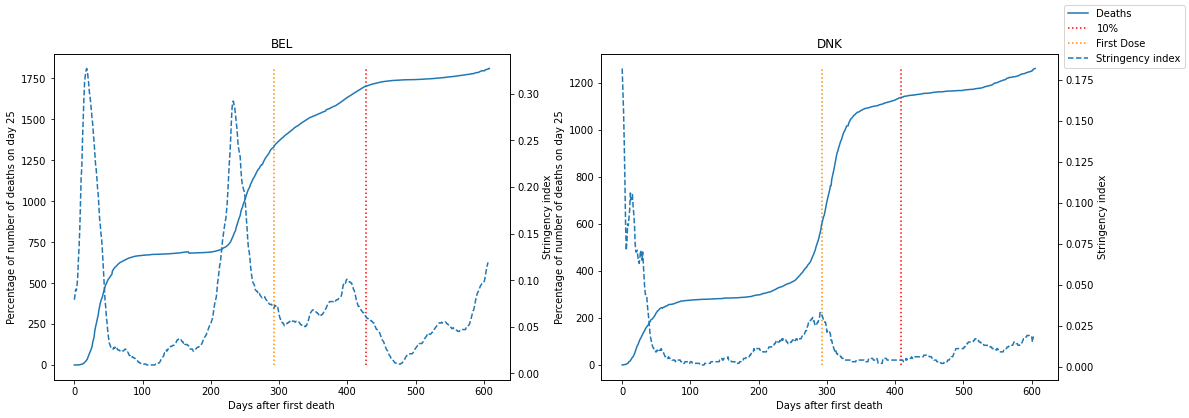

In [132]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(18,6))

ax3 = ax1.twinx()
ax1.plot(tables[bel_idx].index, tables[bel_idx]['percent_deaths'], label='Deaths', color='C0')
ax3.plot(tables[bel_idx].index, tables[bel_idx]['positive_rate'], label='Stringency index', color='C0', linestyle='--')
ax1.vlines(x=bel_ten_perc, ymin=min(tables[bel_idx]['percent_deaths']), ymax=max(tables[bel_idx]['percent_deaths']), linestyle='dotted', color='red', label="10%")
ax1.vlines(x=bel_first_dose, ymin=min(tables[bel_idx]['percent_deaths']), ymax=max(tables[bel_idx]['percent_deaths']), linestyle='dotted', color='darkorange', label="First Dose")

ax4 = ax2.twinx()
ax2.plot(tables[dnk_idx].index, tables[dnk_idx]['percent_deaths'])
ax4.plot(tables[dnk_idx].index, tables[dnk_idx]['positive_rate'], linestyle='--')
ax2.vlines(x=dnk_ten_perc, ymin=min(tables[dnk_idx]['percent_deaths']), ymax=max(tables[dnk_idx]['percent_deaths']), linestyle='dotted', color='red')
ax2.vlines(x=dnk_first_dose, ymin=min(tables[dnk_idx]['percent_deaths']), ymax=max(tables[dnk_idx]['percent_deaths']), linestyle='dotted', color='darkorange')

fig.legend()
plt.xticks(rotation=90)
ax1.set_xlabel('Days after first death')
ax2.set_xlabel('Days after first death')
ax1.set_title('BEL')
ax2.set_title('DNK')
ax1.set_ylabel('Percentage of number of deaths on day 25')
ax2.set_ylabel('Percentage of number of deaths on day 25')
ax3.set_ylabel('Stringency index')
ax4.set_ylabel('Stringency index')
#plt.tight_layout()
plt.savefig('figures/posrate_vacc_bel_den')

## Deaths and Cases, marked with Vaccination points

## Data on socioeconomic factors and age groups

In [133]:
print(tables[bel_idx]['gdp_per_capita'][0], ' -- ', tables[dnk_idx]['gdp_per_capita'][0], " -- ",  tables[ger_idx]['gdp_per_capita'][0])
print(tables[bel_idx]['median_age'][0], ' -- ', tables[dnk_idx]['median_age'][0])
print(tables[bel_idx]['aged_65_older'][0], ' -- ', tables[dnk_idx]['aged_65_older'][0])
print(tables[bel_idx]['aged_70_older'][0], ' -- ', tables[dnk_idx]['aged_70_older'][0])


42658.575999999994  --  46682.515  --  45229.245
41.8  --  42.3
18.570999999999998  --  19.677
12.849  --  12.325


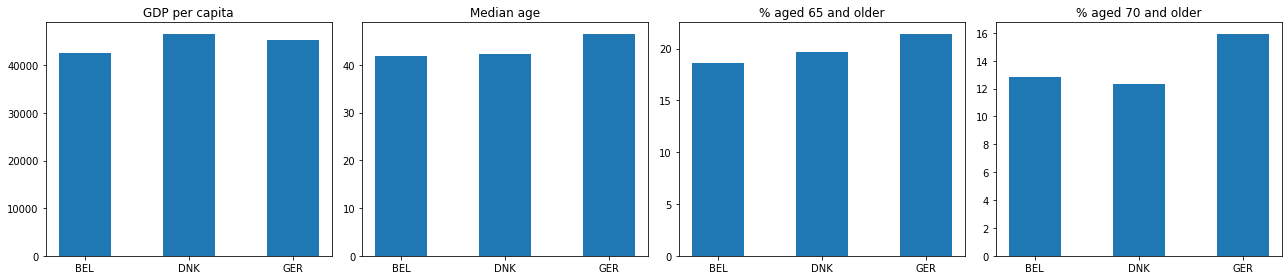

In [24]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18,4))

labels = ['BEL', 'DNK', "GER"]
data = [tables[bel_idx]['gdp_per_capita'][0], tables[dnk_idx]['gdp_per_capita'][0],  tables[ger_idx]['gdp_per_capita'][0]]
r1 = ax1.bar(labels, data, width=0.5)
ax1.set_title('GDP per capita')

data = [tables[bel_idx]['median_age'][0], tables[dnk_idx]['median_age'][0],  tables[ger_idx]['median_age'][0]]
r1 = ax2.bar(labels, data, width=0.5)
ax2.set_title('Median age')

data = [tables[bel_idx]['aged_65_older'][0], tables[dnk_idx]['aged_65_older'][0],  tables[ger_idx]['aged_65_older'][0]]
r1 = ax3.bar(labels, data, width=0.5)
ax3.set_title('% aged 65 and older')

data = [tables[bel_idx]['aged_70_older'][0], tables[dnk_idx]['aged_70_older'][0], tables[ger_idx]['aged_70_older'][0]]
r1 = ax4.bar(labels, data, width=0.5)
ax4.set_title('% aged 70 and older')

#data = [tables[bel_idx]['extreme_poverty'][0], tables[dnk_idx]['extreme_poverty'][0], tables[ger_idx]['extreme_poverty'][0]]
#r1 = ax5.bar(labels, data, width=0.5)
#ax5.set_title('% population in extreme poverty')

plt.tight_layout()
plt.savefig('figures/talk/socioeconomic_bel_dnk')

## Two countries with similar test strategy but different Vaccination: DNK & KOR

In [135]:
prt_tests_yesterday = tables[prt_idx]['tests_per_case'].tail(2)
prt_vacc = tables[prt_idx]['people_fully_vaccinated_per_hundred']
prt_10 = tables[prt_idx]['people_fully_vaccinated_per_hundred'].loc[prt_vacc >= 10]
prt_fd = tables[prt_idx]['people_fully_vaccinated_per_hundred'].loc[prt_vacc >= 0.0]
prt_first_dose = prt_fd.index[0]
prt_ten_perc = prt_10.index[0]

kor_tests_yesterday = tables[kor_idx]['tests_per_case'].tail(2)
kor_vacc = tables[kor_idx]['people_fully_vaccinated_per_hundred']
kor_10 = tables[kor_idx]['people_fully_vaccinated_per_hundred'].loc[kor_vacc >= 10]
kor_fd = tables[kor_idx]['people_fully_vaccinated_per_hundred'].loc[kor_vacc >= 0.0]
kor_first_dose = kor_fd.index[0]
kor_ten_perc = kor_10.index[0]

No handles with labels found to put in legend.


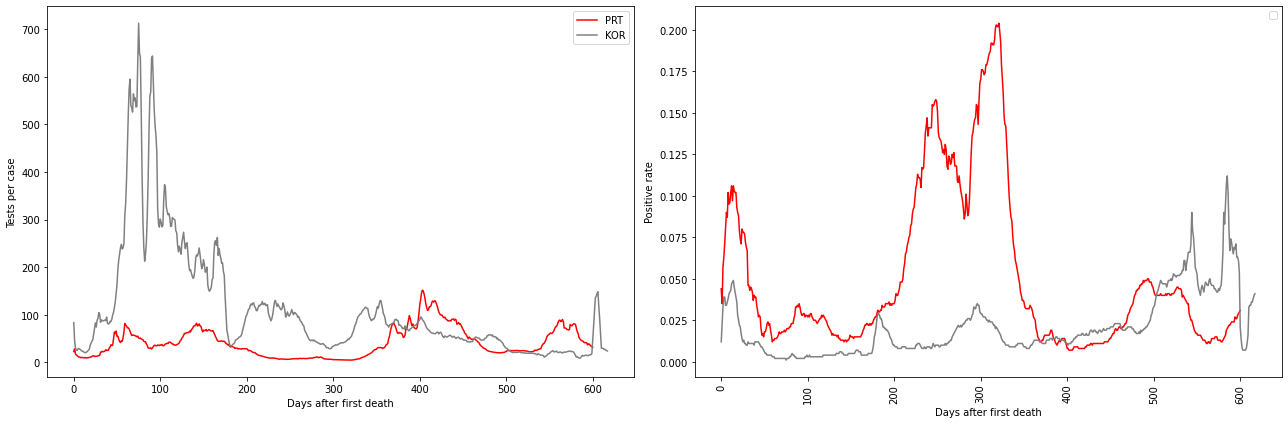

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(18,6))

ax1.plot(tables[prt_idx].index, tables[prt_idx]['tests_per_case'], label='PRT', color=colors['PRT'])
ax1.plot(tables[kor_idx].index, tables[kor_idx]['tests_per_case'], label='KOR', color=colors['KOR'])
ax2.plot(tables[prt_idx].index, tables[prt_idx]['positive_rate'], color=colors['PRT'])
ax2.plot(tables[kor_idx].index, tables[kor_idx]['positive_rate'], color=colors['KOR'])
ax1.legend()
ax2.legend()
plt.xticks(rotation=90)
ax1.set_ylabel('Tests per case')
ax2.set_ylabel('Positive rate')
ax1.set_xlabel('Days after first death')
ax2.set_xlabel('Days after first death')
plt.tight_layout()
plt.savefig('figures//talk/testing_prt_kor')

No handles with labels found to put in legend.


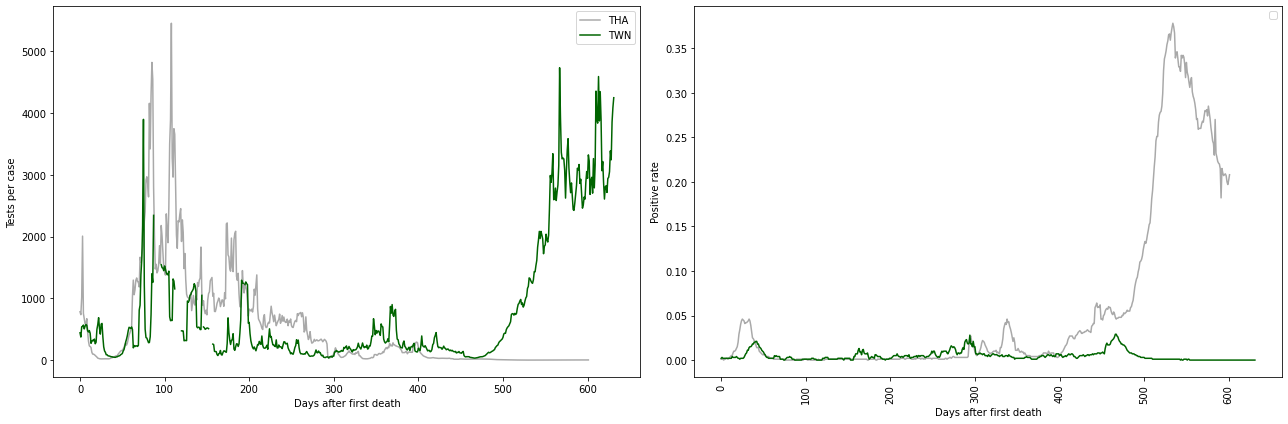

In [137]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(18,6))

ax1.plot(tables[tha_idx].index, tables[tha_idx]['tests_per_case'], label='THA', color=colors['THA'])
ax1.plot(tables[twn_idx].index, tables[twn_idx]['tests_per_case'], label='TWN', color=colors['TWN'])
ax2.plot(tables[tha_idx].index, tables[tha_idx]['positive_rate'], color=colors['THA'])
ax2.plot(tables[twn_idx].index, tables[twn_idx]['positive_rate'], color=colors['TWN'])
ax1.legend()
ax2.legend()
plt.xticks(rotation=90)
ax1.set_ylabel('Tests per case')
ax2.set_ylabel('Positive rate')
ax1.set_xlabel('Days after first death')
ax2.set_xlabel('Days after first death')
plt.tight_layout()
plt.savefig('figures/testing_tha_twn')

No handles with labels found to put in legend.


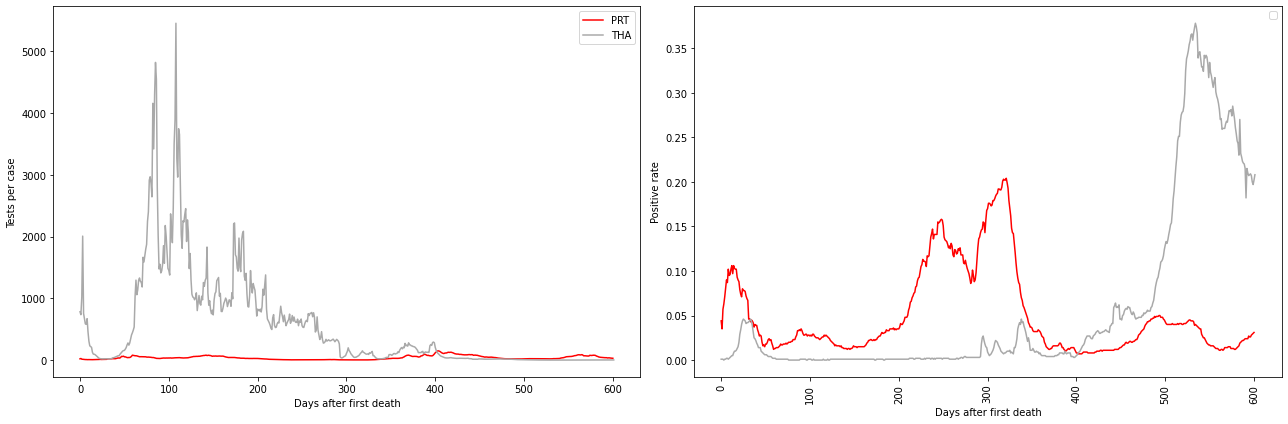

In [138]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(18,6))

ax1.plot(tables[prt_idx].index, tables[prt_idx]['tests_per_case'], label='PRT', color=colors['PRT'])
ax1.plot(tables[tha_idx].index, tables[tha_idx]['tests_per_case'], label='THA', color=colors['THA'])
ax2.plot(tables[prt_idx].index, tables[prt_idx]['positive_rate'], color=colors['PRT'])
ax2.plot(tables[tha_idx].index, tables[tha_idx]['positive_rate'], color=colors['THA'])
ax1.legend()
ax2.legend()
plt.xticks(rotation=90)
ax1.set_ylabel('Tests per case')
ax2.set_ylabel('Positive rate')
ax1.set_xlabel('Days after first death')
ax2.set_xlabel('Days after first death')
plt.tight_layout()
#plt.savefig('figures/testing_prt_kor')

No handles with labels found to put in legend.


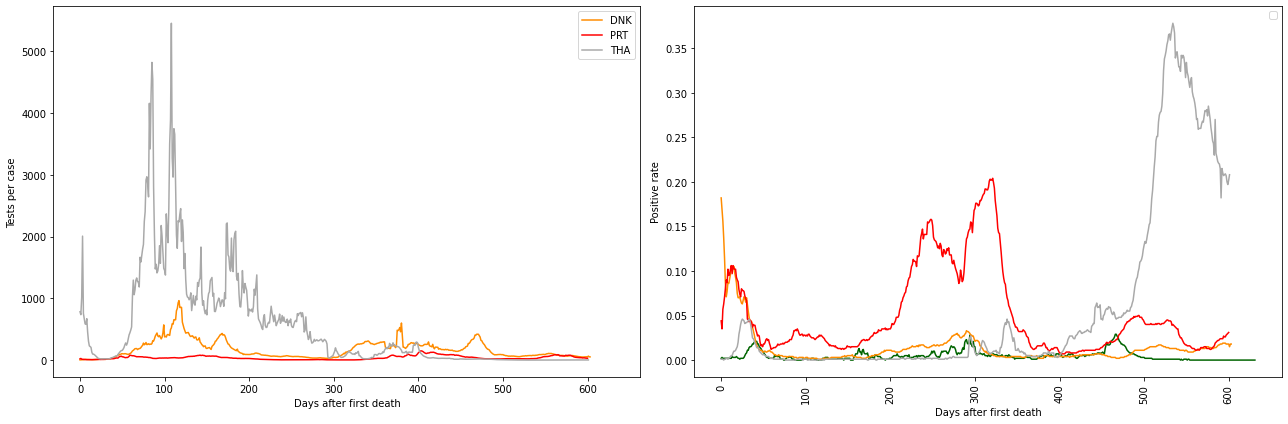

In [139]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(18,6))

#ax1.plot(tables[twn_idx].index, tables[twn_idx]['tests_per_case'], label='TWN', color=colors['TWN'])
ax1.plot(tables[dnk_idx].index, tables[dnk_idx]['tests_per_case'], label='DNK', color=colors['DNK'])
ax1.plot(tables[prt_idx].index, tables[prt_idx]['tests_per_case'], label='PRT', color=colors['PRT'])
ax1.plot(tables[tha_idx].index, tables[tha_idx]['tests_per_case'], label='THA', color=colors['THA'])
ax2.plot(tables[twn_idx].index, tables[twn_idx]['positive_rate'], color=colors['TWN'])
ax2.plot(tables[dnk_idx].index, tables[dnk_idx]['positive_rate'], color=colors['DNK'])
ax2.plot(tables[prt_idx].index, tables[prt_idx]['positive_rate'], color=colors['PRT'])
ax2.plot(tables[tha_idx].index, tables[tha_idx]['positive_rate'], color=colors['THA'])
ax1.legend()
ax2.legend()
plt.xticks(rotation=90)
ax1.set_ylabel('Tests per case')
ax2.set_ylabel('Positive rate')
ax1.set_xlabel('Days after first death')
ax2.set_xlabel('Days after first death')
plt.tight_layout()
#plt.savefig('figures/testing_prt_kor')

## Pearson Correlation

In [140]:
bel_deaths = tables[bel_idx]['total_deaths'][28:].reset_index().drop(columns='index')
bel_deaths2 = bel_deaths.to_numpy(dtype='float').flatten()
bel_cases = tables[bel_idx]['total_cases'][:-28 or None]
bel_cases2 = bel_cases.to_numpy(dtype='float').flatten()

dnk_deaths = tables[dnk_idx]['total_deaths'][28:].reset_index().drop(columns='index')
dnk_deaths2 = dnk_deaths.to_numpy(dtype='float').flatten()
dnk_cases = tables[dnk_idx]['total_cases'][:-28 or None]
dnk_cases2 = dnk_cases.to_numpy(dtype='float').flatten()

d_d = tables[ger_idx]['total_deaths'][28:].reset_index().drop(columns='index')
d_d2 = d_d.to_numpy(dtype='float').flatten()
d_c = tables[ger_idx]['total_cases'][:-28 or None]
d_c2 = d_c.to_numpy(dtype='float').flatten()

i_d = tables[ita_idx]['total_deaths'][28:].reset_index().drop(columns='index')
i_d2 = i_d.to_numpy(dtype='float').flatten()
i_c = tables[ita_idx]['total_cases'][:-28 or None]
i_c2 = i_c.to_numpy(dtype='float').flatten()

corr = scipy.pearsonr(bel_deaths2[:450], bel_cases2[:450])
corr_vacc = scipy.pearsonr(bel_deaths2[450:], bel_cases2[450:])

dnk = scipy.pearsonr(dnk_deaths2[:450], dnk_cases2[:450])
dnk_vacc = scipy.pearsonr(dnk_deaths2[450:], dnk_cases2[450:])

d = scipy.pearsonr(d_d2[:500], d_c2[:500])
d_v = scipy.pearsonr(d_d2[500:], d_c2[500:])


print("BEL ", corr)
print("BEL Vacc", corr_vacc)
print("DNK", dnk)
print("DNK Vacc", dnk_vacc)
print("GER", d)
print("GER Vacc", d_v)
print("Italy :300 ", scipy.pearsonr(i_d2[:450], i_c2[:450]), "300: ", scipy.pearsonr(i_d2[450:], i_c2[450:]))

BEL  (0.9847762212404971, 0.0)
BEL Vacc (0.9809651246971495, 1.0803215208957081e-93)
DNK (0.9905669094212963, 0.0)
DNK Vacc (0.9784303888954831, 3.634851488318364e-88)
GER (0.9900535442883279, 0.0)
GER Vacc (0.9917628835109913, 4.548646848048375e-74)
Italy :300  (0.9892470140906319, 0.0) 300:  (0.9979351192543926, 2.302563477833501e-178)


## Other countries

In [143]:
ger_10 = (tables[ger_idx]['people_fully_vaccinated_per_hundred'].loc[tables[ger_idx]['people_fully_vaccinated_per_hundred'] >= 10]).index[0]
ger_fd = (tables[ger_idx]['people_fully_vaccinated_per_hundred'].loc[tables[ger_idx]['people_fully_vaccinated_per_hundred'] >= 0.0]).index[0]
ger_50 = (tables[ger_idx]['people_fully_vaccinated_per_hundred'].loc[tables[ger_idx]['people_fully_vaccinated_per_hundred'] >= 50]).index[0]

ita_10 = (tables[ita_idx]['people_fully_vaccinated_per_hundred'].loc[tables[ita_idx]['people_fully_vaccinated_per_hundred'] >= 10]).index[0]
ita_50 = (tables[ita_idx]['people_fully_vaccinated_per_hundred'].loc[tables[ita_idx]['people_fully_vaccinated_per_hundred'] >= 50]).index[0]
ita_fd = (tables[ita_idx]['people_fully_vaccinated_per_hundred'].loc[tables[ita_idx]['people_fully_vaccinated_per_hundred'] >= 0.0]).index[0]

usa_10 = (tables[usa_idx]['people_fully_vaccinated_per_hundred'].loc[tables[usa_idx]['people_fully_vaccinated_per_hundred'] >= 10]).index[0]
usa_50 = (tables[usa_idx]['people_fully_vaccinated_per_hundred'].loc[tables[usa_idx]['people_fully_vaccinated_per_hundred'] >= 50]).index[0]
usa_fd = (tables[usa_idx]['people_fully_vaccinated_per_hundred'].loc[tables[usa_idx]['people_fully_vaccinated_per_hundred'] >= 0.0]).index[0]

bel_10 = (tables[bel_idx]['people_fully_vaccinated_per_hundred'].loc[tables[bel_idx]['people_fully_vaccinated_per_hundred'] >= 10]).index[0]
bel_50 = (tables[bel_idx]['people_fully_vaccinated_per_hundred'].loc[tables[bel_idx]['people_fully_vaccinated_per_hundred'] >= 50]).index[0]
bel_fd = (tables[bel_idx]['people_fully_vaccinated_per_hundred'].loc[tables[bel_idx]['people_fully_vaccinated_per_hundred'] >= 0.0]).index[0]

dnk_10 = (tables[dnk_idx]['people_fully_vaccinated_per_hundred'].loc[tables[dnk_idx]['people_fully_vaccinated_per_hundred'] >= 10]).index[0]
dnk_50 = (tables[dnk_idx]['people_fully_vaccinated_per_hundred'].loc[tables[dnk_idx]['people_fully_vaccinated_per_hundred'] >= 50]).index[0]
dnk_fd = (tables[dnk_idx]['people_fully_vaccinated_per_hundred'].loc[tables[dnk_idx]['people_fully_vaccinated_per_hundred'] >= 0.0]).index[0]

prt_10 = (tables[prt_idx]['people_fully_vaccinated_per_hundred'].loc[tables[prt_idx]['people_fully_vaccinated_per_hundred'] >= 10]).index[0]
prt_50 = (tables[prt_idx]['people_fully_vaccinated_per_hundred'].loc[tables[prt_idx]['people_fully_vaccinated_per_hundred'] >= 50]).index[0]
prt_fd = (tables[prt_idx]['people_fully_vaccinated_per_hundred'].loc[tables[prt_idx]['people_fully_vaccinated_per_hundred'] >= 0.0]).index[0]
prt_80 = (tables[prt_idx]['people_fully_vaccinated_per_hundred'].loc[tables[prt_idx]['people_fully_vaccinated_per_hundred'] >= 80]).index[0]


kor_10 = (tables[kor_idx]['people_fully_vaccinated_per_hundred'].loc[tables[kor_idx]['people_fully_vaccinated_per_hundred'] >= 10]).index[0]
kor_fd = (tables[kor_idx]['people_fully_vaccinated_per_hundred'].loc[tables[kor_idx]['people_fully_vaccinated_per_hundred'] >= 0.0]).index[0]

gbr_10 = (tables[gbr_idx]['people_fully_vaccinated_per_hundred'].loc[tables[gbr_idx]['people_fully_vaccinated_per_hundred'] >= 10]).index[0]
gbr_50 = (tables[gbr_idx]['people_fully_vaccinated_per_hundred'].loc[tables[gbr_idx]['people_fully_vaccinated_per_hundred'] >= 50]).index[0]
gbr_fd = (tables[gbr_idx]['people_fully_vaccinated_per_hundred'].loc[tables[gbr_idx]['people_fully_vaccinated_per_hundred'] >= 0.0]).index[0]

twn_10 = (tables[twn_idx]['people_fully_vaccinated_per_hundred'].loc[tables[twn_idx]['people_fully_vaccinated_per_hundred'] >= 10]).index[0]
#twn_50 = (tables[twn_idx]['people_fully_vaccinated_per_hundred'].loc[tables[twn_idx]['people_fully_vaccinated_per_hundred'] >= 50]).index[0]
twn_fd = (tables[twn_idx]['people_fully_vaccinated_per_hundred'].loc[tables[twn_idx]['people_fully_vaccinated_per_hundred'] >= 0.0]).index[0]

tha_10 = (tables[tha_idx]['people_fully_vaccinated_per_hundred'].loc[tables[tha_idx]['people_fully_vaccinated_per_hundred'] >= 10]).index[0]
#tha_50 = (tables[tha_idx]['people_fully_vaccinated_per_hundred'].loc[tables[tha_idx]['people_fully_vaccinated_per_hundred'] >= 50]).index[0]
tha_fd = (tables[tha_idx]['people_fully_vaccinated_per_hundred'].loc[tables[tha_idx]['people_fully_vaccinated_per_hundred'] >= 0.0]).index[0]


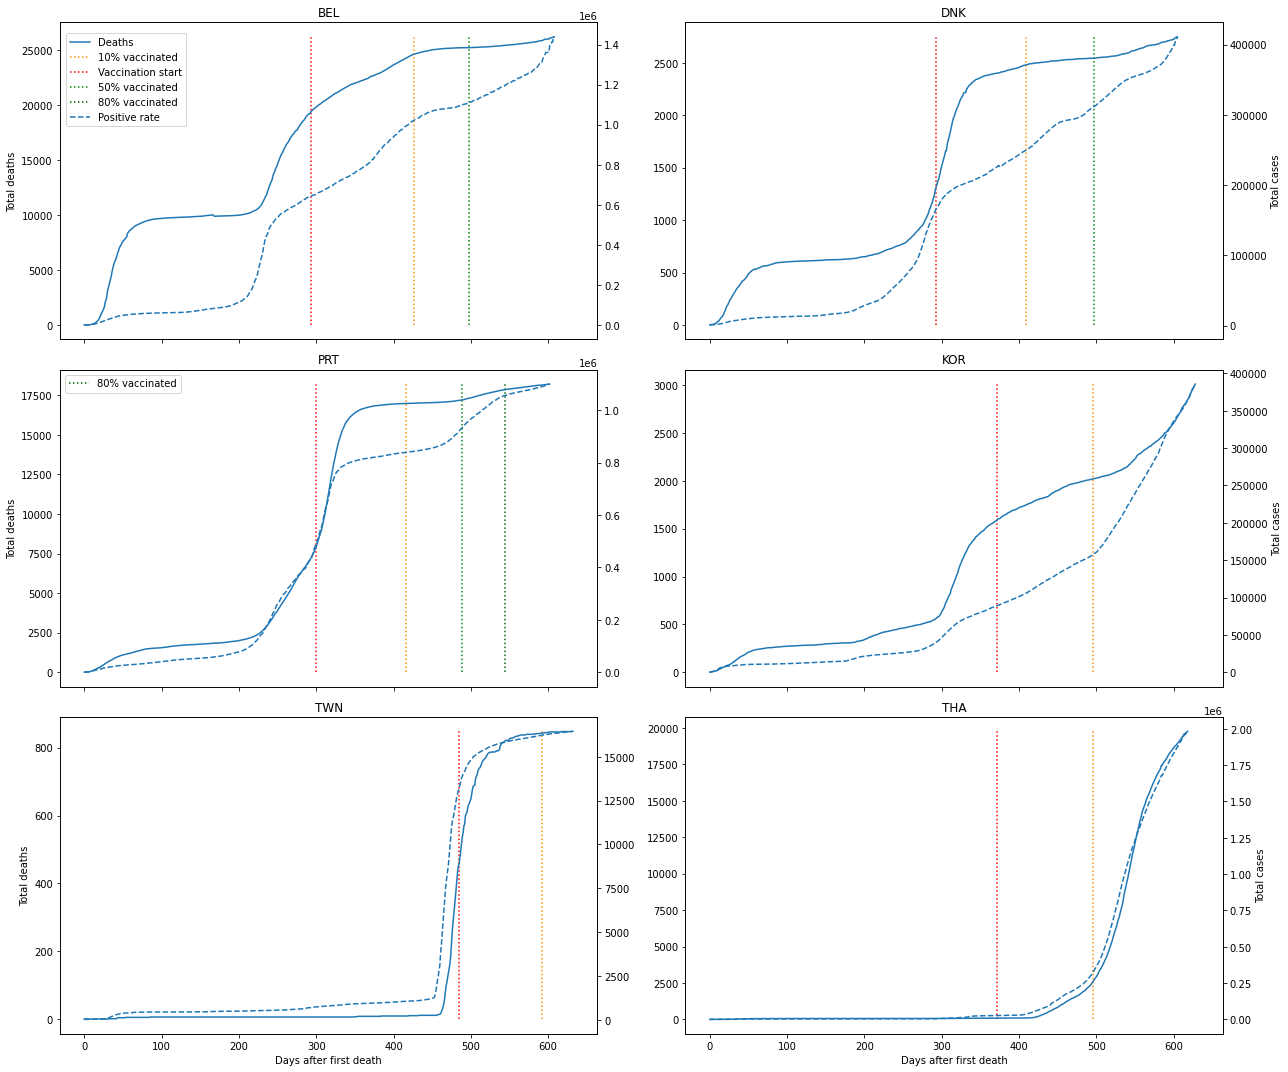

In [144]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharex=True, sharey=False, figsize=(18,15))


ax11 = ax1.twinx()
ax1.plot(tables[bel_idx]['percent_deaths'].index, tables[bel_idx]['total_deaths'], color='C0', label='Deaths')
ax11.plot(tables[bel_idx]['total_cases'].index, tables[bel_idx]['total_cases'], color='C0', linestyle='dashed', label='Positive rate')
ax1.vlines(x=bel_10, ymin=0, ymax=max(tables[bel_idx]['total_deaths']), linestyle='dotted', color='darkorange', label='10% vaccinated')
ax1.vlines(x=bel_fd, ymin=0, ymax=max(tables[bel_idx]['total_deaths']), linestyle='dotted', color='red', label='Vaccination start')
ax1.vlines(x=bel_50, ymin=0, ymax=max(tables[bel_idx]['total_deaths']), linestyle='dotted', color='green', label='50% vaccinated')
ax1.set_title("BEL")
ax1.set_ylabel("Total deaths")

ax21 = ax2.twinx()
ax2.plot(tables[dnk_idx]['percent_deaths'].index, tables[dnk_idx]['total_deaths'], color='C0')
ax21.plot(tables[dnk_idx]['total_cases'].index, tables[dnk_idx]['total_cases'], color='C0', linestyle='dashed')
ax2.vlines(x=dnk_10, ymin=0, ymax=max(tables[dnk_idx]['total_deaths']), linestyle='dotted', color='darkorange')
ax2.vlines(x=dnk_fd, ymin=0, ymax=max(tables[dnk_idx]['total_deaths']), linestyle='dotted', color='red')
ax2.vlines(x=dnk_50, ymin=0, ymax=max(tables[dnk_idx]['total_deaths']), linestyle='dotted', color='green')
ax2.set_title("DNK")
ax21.set_ylabel("Total cases")

ax31 = ax3.twinx()
ax3.plot(tables[prt_idx]['percent_deaths'].index, tables[prt_idx]['total_deaths'], color='C0')
ax31.plot(tables[prt_idx]['total_cases'].index, tables[prt_idx]['total_cases'], color='C0', linestyle='dashed')
ax3.vlines(x=prt_10, ymin=0, ymax=max(tables[prt_idx]['total_deaths']), linestyle='dotted', color='darkorange')
ax3.vlines(x=prt_fd, ymin=0, ymax=max(tables[prt_idx]['total_deaths']), linestyle='dotted', color='red')
ax3.vlines(x=prt_50, ymin=0, ymax=max(tables[prt_idx]['total_deaths']), linestyle='dotted', color='green')
ax3.vlines(x=prt_80, ymin=0, ymax=max(tables[prt_idx]['total_deaths']), linestyle='dotted', color='darkgreen', label='80% vaccinated')
ax3.set_title("PRT")
ax3.set_ylabel("Total deaths")
ax3.legend()

ax41 = ax4.twinx()
ax4.plot(tables[kor_idx]['percent_deaths'].index, tables[kor_idx]['total_deaths'], color='C0')
ax41.plot(tables[kor_idx]['total_cases'].index, tables[kor_idx]['total_cases'], color='C0', linestyle='dashed')
ax4.vlines(x=kor_10, ymin=0, ymax=max(tables[kor_idx]['total_deaths']), linestyle='dotted', color='darkorange')
ax4.vlines(x=kor_fd, ymin=0, ymax=max(tables[kor_idx]['total_deaths']), linestyle='dotted', color='red')
ax4.set_title("KOR")
ax41.set_ylabel('Total cases')

ax51 = ax5.twinx()
ax5.plot(tables[twn_idx]['percent_deaths'].index, tables[twn_idx]['total_deaths'], color='C0')
ax51.plot(tables[twn_idx]['total_cases'].index, tables[twn_idx]['total_cases'], color='C0', linestyle='dashed')
ax5.vlines(x=twn_10, ymin=0, ymax=max(tables[twn_idx]['total_deaths']), linestyle='dotted', color='darkorange')
ax5.vlines(x=twn_fd, ymin=0, ymax=max(tables[twn_idx]['total_deaths']), linestyle='dotted', color='red')
ax5.set_title("TWN")
ax5.set_ylabel("Total deaths")
ax5.set_xlabel("Days after first death")

ax61 = ax6.twinx()
ax6.plot(tables[tha_idx]['percent_deaths'].index, tables[tha_idx]['total_deaths'], color='C0')
ax61.plot(tables[tha_idx]['total_cases'].index, tables[tha_idx]['total_cases'], color='C0', linestyle='dashed')
ax6.vlines(x=kor_10, ymin=0, ymax=max(tables[tha_idx]['total_deaths']), linestyle='dotted', color='darkorange')
ax6.vlines(x=kor_fd, ymin=0, ymax=max(tables[tha_idx]['total_deaths']), linestyle='dotted', color='red')
ax6.set_title("THA")
ax61.set_ylabel("Total cases")
ax6.set_xlabel("Days after first death")

fig.legend(loc='upper right', bbox_to_anchor=(0.15, 0.97))
plt.tight_layout()
plt.savefig("figures/deaths_cases_6")


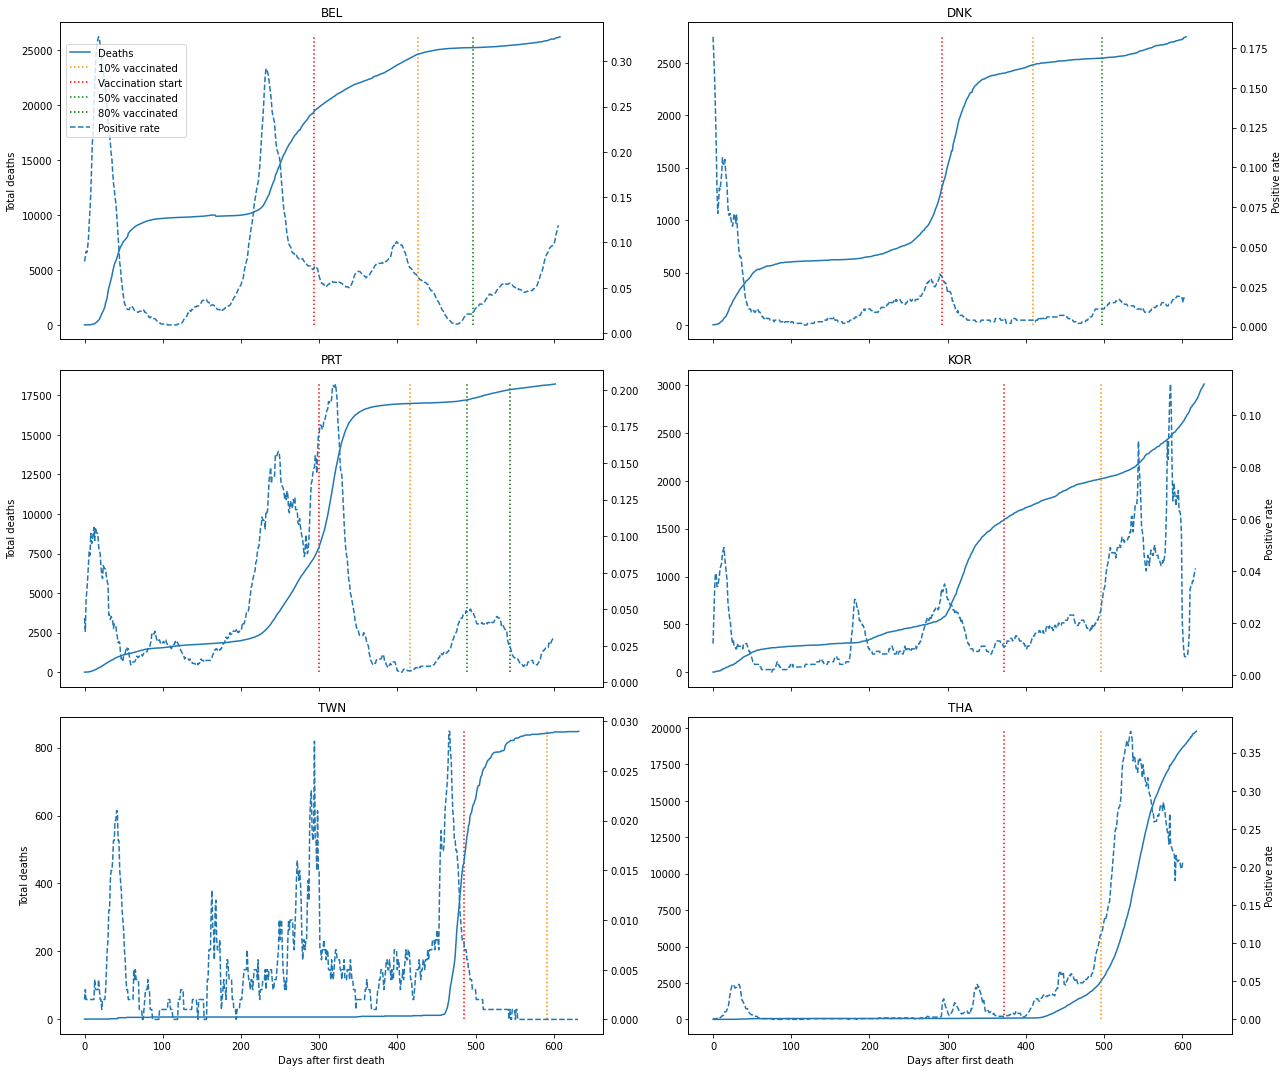

In [145]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharex=True, sharey=False, figsize=(18,15))


ax11 = ax1.twinx()
ax1.plot(tables[bel_idx]['percent_deaths'].index, tables[bel_idx]['total_deaths'], color='C0', label='Deaths')
ax11.plot(tables[bel_idx]['positive_rate'].index, tables[bel_idx]['positive_rate'], color='C0', linestyle='dashed', label='Positive rate')
ax1.vlines(x=bel_10, ymin=0, ymax=max(tables[bel_idx]['total_deaths']), linestyle='dotted', color='darkorange', label='10% vaccinated')
ax1.vlines(x=bel_fd, ymin=0, ymax=max(tables[bel_idx]['total_deaths']), linestyle='dotted', color='red', label='Vaccination start')
ax1.vlines(x=bel_50, ymin=0, ymax=max(tables[bel_idx]['total_deaths']), linestyle='dotted', color='green', label='50% vaccinated')
ax1.set_title("BEL")
ax1.set_ylabel("Total deaths")

ax21 = ax2.twinx()
ax2.plot(tables[dnk_idx]['percent_deaths'].index, tables[dnk_idx]['total_deaths'], color='C0')
ax21.plot(tables[dnk_idx]['positive_rate'].index, tables[dnk_idx]['positive_rate'], color='C0', linestyle='dashed')
ax2.vlines(x=dnk_10, ymin=0, ymax=max(tables[dnk_idx]['total_deaths']), linestyle='dotted', color='darkorange')
ax2.vlines(x=dnk_fd, ymin=0, ymax=max(tables[dnk_idx]['total_deaths']), linestyle='dotted', color='red')
ax2.vlines(x=dnk_50, ymin=0, ymax=max(tables[dnk_idx]['total_deaths']), linestyle='dotted', color='green')
ax2.set_title("DNK")
ax21.set_ylabel("Positive rate")

ax31 = ax3.twinx()
ax3.plot(tables[prt_idx]['percent_deaths'].index, tables[prt_idx]['total_deaths'], color='C0')
ax31.plot(tables[prt_idx]['positive_rate'].index, tables[prt_idx]['positive_rate'], color='C0', linestyle='dashed')
ax3.vlines(x=prt_10, ymin=0, ymax=max(tables[prt_idx]['total_deaths']), linestyle='dotted', color='darkorange')
ax3.vlines(x=prt_fd, ymin=0, ymax=max(tables[prt_idx]['total_deaths']), linestyle='dotted', color='red')
ax3.vlines(x=prt_50, ymin=0, ymax=max(tables[prt_idx]['total_deaths']), linestyle='dotted', color='green')
ax3.vlines(x=prt_80, ymin=0, ymax=max(tables[prt_idx]['total_deaths']), linestyle='dotted', color='darkgreen', label='80% vaccinated')
ax3.set_title("PRT")
ax3.set_ylabel("Total deaths")

ax41 = ax4.twinx()
ax4.plot(tables[kor_idx]['percent_deaths'].index, tables[kor_idx]['total_deaths'], color='C0')
ax41.plot(tables[kor_idx]['positive_rate'].index, tables[kor_idx]['positive_rate'], color='C0', linestyle='dashed')
ax4.vlines(x=kor_10, ymin=0, ymax=max(tables[kor_idx]['total_deaths']), linestyle='dotted', color='darkorange')
ax4.vlines(x=kor_fd, ymin=0, ymax=max(tables[kor_idx]['total_deaths']), linestyle='dotted', color='red')
ax4.set_title("KOR")
ax41.set_ylabel('Positive rate')

ax51 = ax5.twinx()
ax5.plot(tables[twn_idx]['percent_deaths'].index, tables[twn_idx]['total_deaths'], color='C0')
ax51.plot(tables[twn_idx]['positive_rate'].index, tables[twn_idx]['positive_rate'], color='C0', linestyle='dashed')
ax5.vlines(x=twn_10, ymin=0, ymax=max(tables[twn_idx]['total_deaths']), linestyle='dotted', color='darkorange')
ax5.vlines(x=twn_fd, ymin=0, ymax=max(tables[twn_idx]['total_deaths']), linestyle='dotted', color='red')
ax5.set_title("TWN")
ax5.set_ylabel("Total deaths")
ax5.set_xlabel("Days after first death")

ax61 = ax6.twinx()
ax6.plot(tables[tha_idx]['percent_deaths'].index, tables[tha_idx]['total_deaths'], color='C0')
ax61.plot(tables[tha_idx]['positive_rate'].index, tables[tha_idx]['positive_rate'], color='C0', linestyle='dashed')
ax6.vlines(x=kor_10, ymin=0, ymax=max(tables[tha_idx]['total_deaths']), linestyle='dotted', color='darkorange')
ax6.vlines(x=kor_fd, ymin=0, ymax=max(tables[tha_idx]['total_deaths']), linestyle='dotted', color='red')
ax6.set_title("THA")
ax61.set_ylabel("Positive rate")
ax6.set_xlabel("Days after first death")

fig.legend(loc='upper right', bbox_to_anchor=(0.15, 0.96))
plt.tight_layout()

plt.savefig("figures/deaths_posrate_6")


# More experiments (for presentation

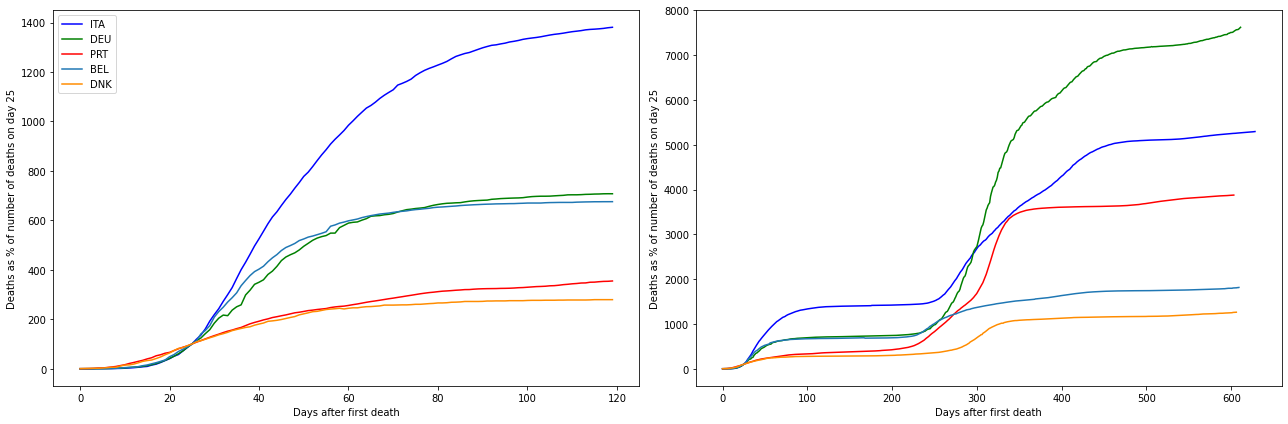

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(18,6))

for table in tables:
    if table['iso_code'].values[0] == 'USA'or table['iso_code'].values[0] == 'TWN' or table['iso_code'].values[0] == 'THA' or table['iso_code'].values[0] == 'SWE' or table['iso_code'].values[0] == 'THA' or table['iso_code'].values[0] == 'GBR' or table['iso_code'].values[0] == 'KOR':
        continue 
    ax1.plot(table[:120].index, table[:120]['percent_deaths'], label=table['iso_code'].values[0], color=colors[table['iso_code'].values[0]])
    ax2.plot(table.index, table['percent_deaths'], label=table['iso_code'].values[0], color=colors[table['iso_code'].values[0]])

ax1.legend()
ax1.set_ylabel('Deaths as % of number of deaths on day 25')
ax1.set_xlabel('Days after first death')
ax2.set_ylabel('Deaths as % of number of deaths on day 25')
ax2.set_xlabel('Days after first death')
plt.tight_layout()
plt.savefig('figures/talk/deaths_2plot')

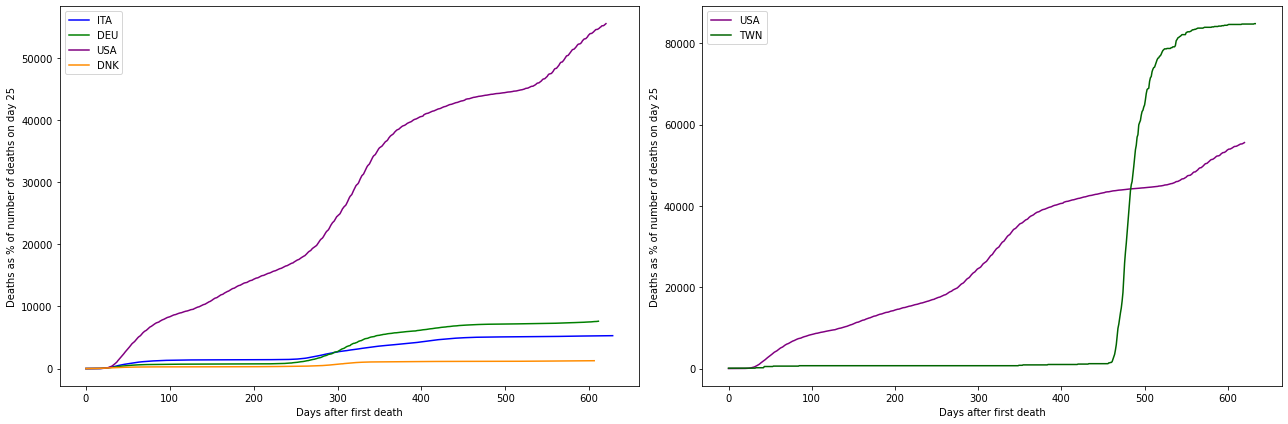

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(18,6))

for table in tables:
    if table['iso_code'].values[0] == 'DEU' or table['iso_code'].values[0] == 'ITA' or table['iso_code'].values[0] == 'DNK' or table['iso_code'].values[0] == 'USA':
        ax1.plot(table.index, table['percent_deaths'], label=table['iso_code'].values[0], color=colors[table['iso_code'].values[0]])
    if table['iso_code'].values[0] == 'USA' or table['iso_code'].values[0] == 'TWN':
        ax2.plot(table.index, table['percent_deaths'], label=table['iso_code'].values[0], color=colors[table['iso_code'].values[0]])


ax1.legend()
ax2.legend()
ax2.set_ylabel('Deaths as % of number of deaths on day 25')
ax1.set_xlabel('Days after first death')
ax1.set_ylabel('Deaths as % of number of deaths on day 25')
ax2.set_xlabel('Days after first death')
plt.tight_layout()
plt.savefig('figures/talk/lim')

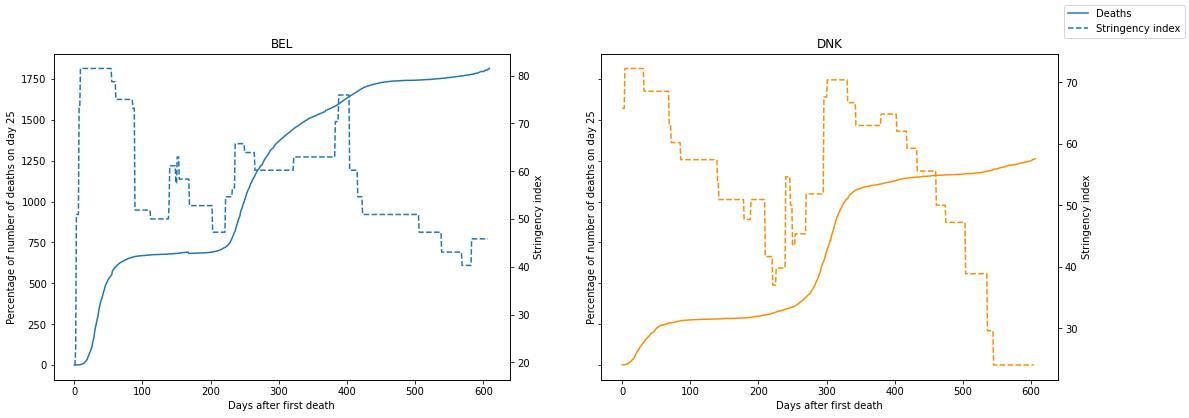

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(18,6))

ax3 = ax1.twinx()
ax1.plot(tables[bel_idx].index, tables[bel_idx]['percent_deaths'], label='Deaths', color='C0')
ax3.plot(tables[bel_idx].index, tables[bel_idx]['stringency_index'], label='Stringency index', color='C0', linestyle='--')

ax4 = ax2.twinx()
ax2.plot(tables[dnk_idx].index, tables[dnk_idx]['percent_deaths'], color='darkorange')
ax4.plot(tables[dnk_idx].index, tables[dnk_idx]['stringency_index'], color='darkorange', linestyle='--')

fig.legend()
plt.xticks(rotation=90)
ax1.set_xlabel('Days after first death')
ax2.set_xlabel('Days after first death')
ax1.set_title('BEL')
ax2.set_title('DNK')
ax1.set_ylabel('Percentage of number of deaths on day 25')
ax2.set_ylabel('Percentage of number of deaths on day 25')
ax3.set_ylabel('Stringency index')
ax4.set_ylabel('Stringency index')
#plt.tight_layout()

plt.savefig('figures/talk/stringency1')

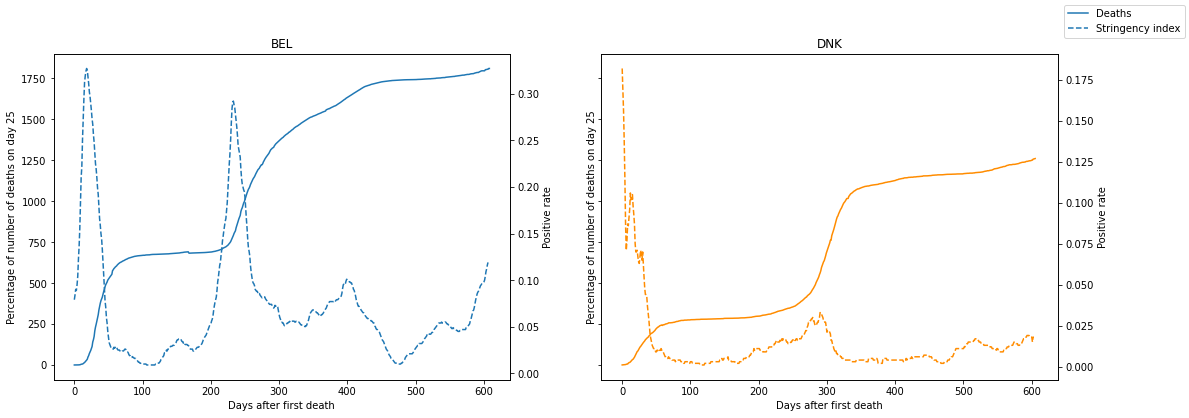

In [82]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(18,6))

ax3 = ax1.twinx()
ax1.plot(tables[bel_idx].index, tables[bel_idx]['percent_deaths'], label='Deaths', color='C0')
ax3.plot(tables[bel_idx].index, tables[bel_idx]['positive_rate'], label='Stringency index', color='C0', linestyle='--')

ax4 = ax2.twinx()
ax2.plot(tables[dnk_idx].index, tables[dnk_idx]['percent_deaths'], color='darkorange')
ax4.plot(tables[dnk_idx].index, tables[dnk_idx]['positive_rate'], color='darkorange', linestyle='--')

fig.legend()
plt.xticks(rotation=90)
ax1.set_xlabel('Days after first death')
ax2.set_xlabel('Days after first death')
ax1.set_title('BEL')
ax2.set_title('DNK')
ax1.set_ylabel('Percentage of number of deaths on day 25')
ax2.set_ylabel('Percentage of number of deaths on day 25')
ax3.set_ylabel('Positive rate')
ax4.set_ylabel('Positive rate')
#plt.tight_layout()
plt.savefig('figures/talk/posrate_bel_den')

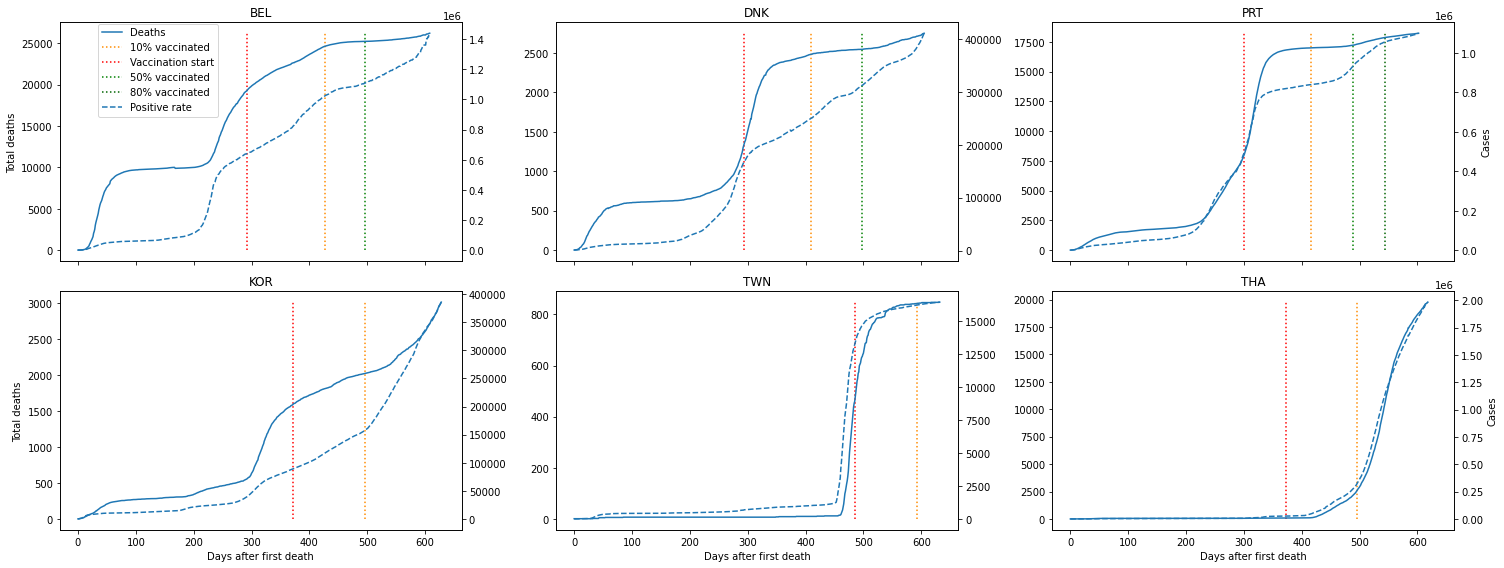

In [147]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex=True, sharey=False, figsize=(21,8))


ax11 = ax1.twinx()
ax1.plot(tables[bel_idx]['percent_deaths'].index, tables[bel_idx]['total_deaths'], color='C0', label='Deaths')
ax11.plot(tables[bel_idx]['total_cases'].index, tables[bel_idx]['total_cases'], color='C0', linestyle='dashed', label='Positive rate')

ax1.set_title("BEL")
ax1.set_ylabel("Total deaths")

ax21 = ax2.twinx()
ax2.plot(tables[dnk_idx]['percent_deaths'].index, tables[dnk_idx]['total_deaths'], color='C0')
ax21.plot(tables[dnk_idx]['total_cases'].index, tables[dnk_idx]['total_cases'], color='C0', linestyle='dashed')

ax2.set_title("DNK")

ax31 = ax3.twinx()
ax3.plot(tables[prt_idx]['percent_deaths'].index, tables[prt_idx]['total_deaths'], color='C0')
ax31.plot(tables[prt_idx]['total_cases'].index, tables[prt_idx]['total_cases'], color='C0', linestyle='dashed')
ax31.set_ylabel('Cases')

ax3.set_title("PRT")

ax41 = ax4.twinx()
ax4.plot(tables[kor_idx]['percent_deaths'].index, tables[kor_idx]['total_deaths'], color='C0')
ax41.plot(tables[kor_idx]['total_cases'].index, tables[kor_idx]['total_cases'], color='C0', linestyle='dashed')
ax4.set_ylabel("Total deaths")
ax4.set_xlabel("Days after first death")
ax4.set_title("KOR")

ax51 = ax5.twinx()
ax5.plot(tables[twn_idx]['percent_deaths'].index, tables[twn_idx]['total_deaths'], color='C0')
ax51.plot(tables[twn_idx]['total_cases'].index, tables[twn_idx]['total_cases'], color='C0', linestyle='dashed')

ax5.set_title("TWN")
ax5.set_xlabel("Days after first death")

ax61 = ax6.twinx()
ax6.plot(tables[tha_idx]['percent_deaths'].index, tables[tha_idx]['total_deaths'], color='C0')
ax61.plot(tables[tha_idx]['total_cases'].index, tables[tha_idx]['total_cases'], color='C0', linestyle='dashed')
ax61.set_ylabel('Positive rate')

ax6.set_title("THA")
ax61.set_ylabel("Cases")
ax6.set_xlabel("Days after first death")

ax1.vlines(x=bel_10, ymin=0, ymax=max(tables[bel_idx]['total_deaths']), linestyle='dotted', color='darkorange', label='10% vaccinated')
ax1.vlines(x=bel_fd, ymin=0, ymax=max(tables[bel_idx]['total_deaths']), linestyle='dotted', color='red', label='Vaccination start')
ax1.vlines(x=bel_50, ymin=0, ymax=max(tables[bel_idx]['total_deaths']), linestyle='dotted', color='green', label='50% vaccinated')
ax2.vlines(x=dnk_10, ymin=0, ymax=max(tables[dnk_idx]['total_deaths']), linestyle='dotted', color='darkorange')
ax2.vlines(x=dnk_fd, ymin=0, ymax=max(tables[dnk_idx]['total_deaths']), linestyle='dotted', color='red')
ax2.vlines(x=dnk_50, ymin=0, ymax=max(tables[dnk_idx]['total_deaths']), linestyle='dotted', color='green')
ax3.vlines(x=prt_10, ymin=0, ymax=max(tables[prt_idx]['total_deaths']), linestyle='dotted', color='darkorange')
ax3.vlines(x=prt_fd, ymin=0, ymax=max(tables[prt_idx]['total_deaths']), linestyle='dotted', color='red')
ax3.vlines(x=prt_50, ymin=0, ymax=max(tables[prt_idx]['total_deaths']), linestyle='dotted', color='green')
ax3.vlines(x=prt_80, ymin=0, ymax=max(tables[prt_idx]['total_deaths']), linestyle='dotted', color='darkgreen', label='80% vaccinated')

ax4.vlines(x=kor_10, ymin=0, ymax=max(tables[kor_idx]['total_deaths']), linestyle='dotted', color='darkorange')
ax4.vlines(x=kor_fd, ymin=0, ymax=max(tables[kor_idx]['total_deaths']), linestyle='dotted', color='red')
ax5.vlines(x=twn_10, ymin=0, ymax=max(tables[twn_idx]['total_deaths']), linestyle='dotted', color='darkorange')
ax5.vlines(x=twn_fd, ymin=0, ymax=max(tables[twn_idx]['total_deaths']), linestyle='dotted', color='red')
ax6.vlines(x=kor_10, ymin=0, ymax=max(tables[tha_idx]['total_deaths']), linestyle='dotted', color='darkorange')
ax6.vlines(x=kor_fd, ymin=0, ymax=max(tables[tha_idx]['total_deaths']), linestyle='dotted', color='red')

fig.legend(loc='upper right', bbox_to_anchor=(0.15, 0.96))
plt.tight_layout()

plt.savefig("figures/talk/deaths_cases")